# MA934  Numerical Methods - Workbook 2

In [1]:
using PyPlot

In [2]:
include("kvpair.jl")
include("llist.jl")
include("ftree.jl");

## Question 1: Linear search using a linked list

The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
2. Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. Verify that your function works.
3. Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. 

In [3]:
# Part 1

# Traverse Function
function traverse(list)
    if !isnull(list)                       # Base case (Do nothing)
        print(get(list).data.key)
        print(" ")
        println(get(list).data.value)
        traverse(get(list).next)           # Recursive case
    end
end

# Creating random array of Key_Value pairs
x = rand(1:10,5)
values = Array{KVPair}(5)
for i=1:5
    values[i]=KVPair(i,x[i])
end

# Buliding the list
L = Nullable{LList}()                      
L = buildLList(values)

# Testing the function
traverse(L)

1 5.0
2 6.0
3 9.0
4 9.0
5 7.0


In [4]:
# Part 2

# Search_list Function
function search_list(list, k)
    if !isnull(list)                                    
        if get(list).data.key == k                      # Base case when list is not null
            return(get(list).data)
        else
            return(search_list(get(list).next,k))       # Recursive case
        end
    else
        return(Nullable{KVPair})                        # Base case when list is null
    end
end

# Testing the function
search_list(L, 3)

KVPair(3, 9.0)

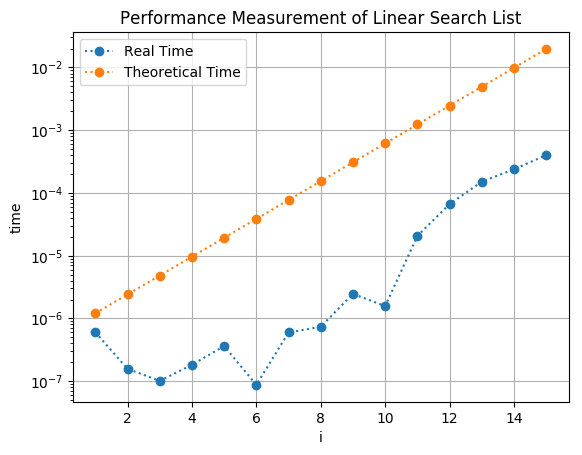

In [5]:
# Part 3

seed = 1235 
rng = MersenneTwister(seed)

# Times Variables declarations and definition
time1 = zeros(15)
time_t1 = zeros(15)

# Measuring the time for different size of list
for i=1:15
    n=2^i                                               # Size of List
    x = rand(rng, n)                                    # List items chosen uniformly random
    
    
    # Creating the List
    values = Array{KVPair}(n)                           # Creating an array of Key_Value pairs
    for j=1:n
        values[j]=KVPair(j,x[j])                        # Populating the array with the values of x
    end 
    L1 = Nullable{LList}()
    L1 = buildLList(values)
    
    # Measuring the time
    k = rand(1:n)
    t = @timed search_list(L1,k);
    time1[i] = t[2]                                     # Real time measurement
    time_t1[i] = time1[1]*(n)                           # Theoretical time measurement

end

# Plots
j = 1:15
semilogy(j,time1,":o",label="Real Time")
semilogy(j,time_t1,":o",label="Theoretical Time")
xlabel("i")
ylabel("time")
legend()
grid()
title("Performance Measurement of Linear Search List");

<font color=blue>
Looks roughly linear! Same comment about axis labelling applies. If you have problems measuring non-zero run times for smaller arrays, you measure the time for n searches and divide by n. This works pretty well and also tends to average out some of the fluctuations.
</font>

<font color=blue>
13/15
</font>

For small values of n, sometimes the return value of @timed macro is zero, which will be undefined when plotting the log values. Other than this problem it seems that computational cost of search_list function grows linearly O(n), with the length of the list.

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

In [6]:
# Part 1

n=10
seed = 1235 
rng = MersenneTwister(seed)

# Intervals and Partial Sums
y = rand(rng, n);
x = zeros(n)

# Creating list 
values = Array{KVPair}(10)
for i=1:10
    for j=1:i                        # Computing partial sums
        x[i]=x[i]+y[j]
    end
    values[i]=KVPair(i,x[i])
end
L = Nullable{LList}()
L = buildLList(values)

# Testing the values
traverse(L)

1 0.09515880533766441
2 0.3660566209216942
3 1.2723720624303905
4 2.1059565816183605
5 3.0510113282306257
6 3.494680246826905
7 4.3992572660623805
8 5.340855742136259
9 5.378445491782055
10 6.374527549662986


In [7]:
# Part 2

# Function of Interval Membership Using List Data Structure
function intervalmembershipList(list, x)
    if !isnull(list)                                                 # Recursive case
        if get(list).data.value > x
            return(get(list).data)
        else
            return(intervalmembershipList(get(list).next,x))
        end
    else
        return(Nullable{KVPair})                                     # Base case (return Nulll)
    end
end

intervalmembershipList(L, 5.6)

KVPair(10, 6.374527549662986)

In [8]:

seed = 1235 
rng = MersenneTwister(seed)

# Times Variables declarations and definition
time2 = zeros(15)
time_t2 = zeros(15)

for z=1:15
    
    n=2^z                                             # Size of the List
    I = rand(rng, n)                                  # Intervals
    x = zeros(n)                                      # Partial Sums

    # Creating the List
    values = Array{KVPair}(n)
    for i=1:n
        for j=1:i                                     # Computing partial sums
            x[i]=x[i]+I[j]
        end
        values[i]=KVPair(i,x[i])
    end 
    L2 = Nullable{LList}()
    L2 = buildLList(values)
    
    # Measuring the time
    k = rand(1:n)
    t = @timed intervalmembershipList(L2, k)
    time2[z] = t[2]
    time_t2[z] = (n)*time2[1]
end


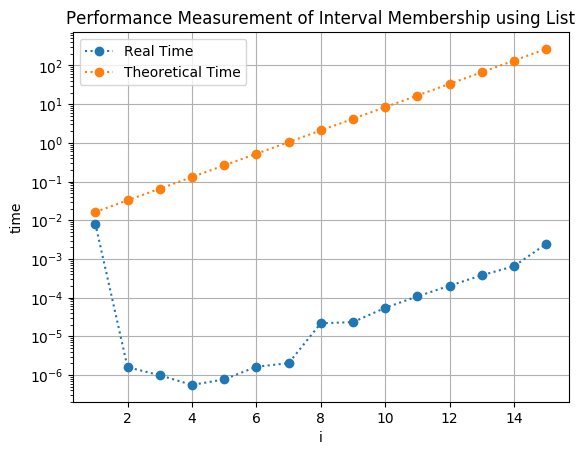

In [9]:
# Plots
j = 1:15
semilogy(j, time2,":o",label="Real Time")
semilogy(j, time_t2,":o",label="Theoretical Time")
xlabel("i")
ylabel("time")
legend()
grid()
title("Performance Measurement of Interval Membership using List");

Other than the distortion for small values of n, it seems that the computational cost of interval membership function grows linearly O(n), with the length of the list.

In [10]:
# Part3

n=5
X = rand(rng, 5)

# Calculating the array of partial sums
values = Array{KVPair}(5)
for i in 1:n
    values[i] = KVPair(i,X[i])
end

#Creating Tree
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T = buildFTree(T, values);

# Function of Interval Membership Using Tree Data Structure
function intervalmembership(t,x)
    if isnull(get(t).left) & isnull(get(t).right)
        return(get(t).data)
    elseif x < get(get(t).left).data.value
        return(intervalmembership(get(t).left,x))
    else
        return(intervalmembership(get(t).right,x-(get(get(t).left).data.value)))
    end
end


intervalmembership (generic function with 1 method)

In [11]:

seed = 1235 
rng = MersenneTwister(seed)

# Times Variables declarations and definition
time3 = zeros(15)
time_t3 = zeros(15)

for z=1:15
    
    n=2^z                                                # Size of the List
    I = rand(rng,n)                                      # Intervals
    values = Array{KVPair}(n)                            # Partial Sums
    for i=1:n
        values[i]=KVPair(i,I[i])
    end
    
    # Creating Tree
    T = Nullable{FTree}(FTree(KVPair(0,0.0)))
    T = buildFTree(T, values);
    
    # Measuring the time
    k = rand(1:n)
    t = @timed intervalmembership(T, k)
    time3[z] = t[2]
    time_t3[z] = (log(n))*time2[1]
end

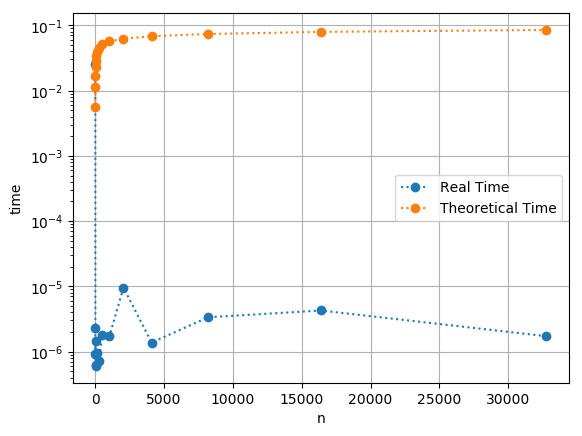

In [12]:
# Plots
i = 1:15
j=2.^i
semilogy(j,time3,":o",label="Real Time")
semilogy(j,time_t3,":o",label="Theoretical Time")
xlabel("n")
ylabel("time")
legend()
grid();

<font color=blue>
This would probably be better on a log-log scale since all of the data points are squeezed into the left of the figure. You should also rescale the theoretical curve to make it more comparable with the numerical measurements. The $O(\log(n))$ theoretical result is only a bound - the prefactor doesn't have to be 1.
</font>

<font color=blue>
13/15
</font>

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$

In [13]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0


r = (D/2.0)/(dx*dx)
totalRate = 2.0*N*r
dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N)
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

LoadError: [91mUndefVarError: plot! not defined[39m

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.



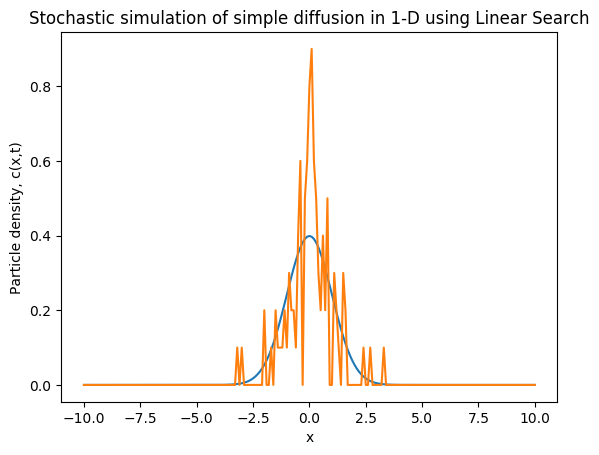

In [14]:
# Part 1
# Using Linear 

L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1
Dexp = randexp(N)
Dexp = [Dexp; Dexp]
t=0.0


r = (Dexp./2.0)./(dx*dx)
totalRate = sum(r)
dt = 1.0/totalRate
T=1.0

#Creating Partial sums
x = zeros(2*N)
values = Array{KVPair}(2*N)
for i=1:2*N
    for j=1:i
        x[i]=x[i]+r[j]
    end
    values[i]=KVPair(i,x[i])
end

#Creating List
L = Nullable{LList}()
L = buildLList(values)

# This is the main loop
while t < T
    # Pick an event
    ran = rand()*totalRate 
    k = intervalmembershipList(L, ran).key
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt

end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot(X, P, label="Numerical estimate of particle density")
xlabel("x")
ylabel("Particle density, c(x,t)")
title("Stochastic simulation of simple diffusion in 1-D using Linear Search");


The largest value of N that I could simulate in reasonable time (17 minutes) was about 10000.

<font color=blue>
You are more patient than me ...
</font>

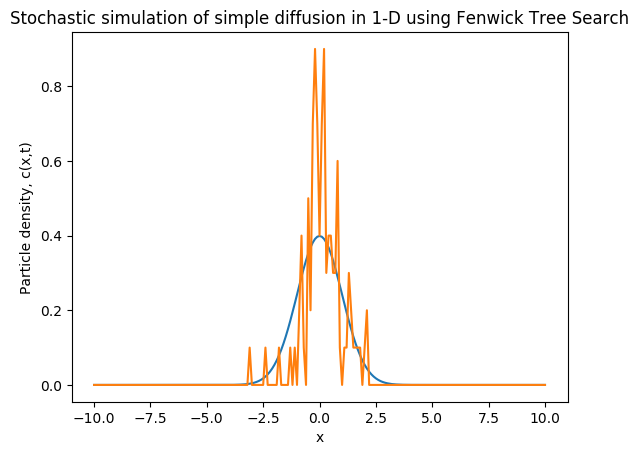

PyObject <matplotlib.text.Text object at 0x12f20df50>

In [18]:
# Part 2
# Using Fenwick tree Search

L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1
Dexp = randexp(N)
Dexp = [Dexp; Dexp]
t=0.0


r = (Dexp./2.0)./(dx*dx)
totalRate = sum(r)
dt = 1.0/totalRate
T=1.0

#Creating Tree
values = Array{KVPair}(2*N)
for i=1:2*N
    values[i]=KVPair(i,r[i])
end
T3 = Nullable{FTree}(FTree(KVPair(0,0.0)))
T3 = buildFTree(T3, values);

# Thisvalues[i] is the main loop
while t < T
    # Pick an event
    ran = rand()*totalRate
    l = intervalmembership(T3, ran).key
    if l<=N
        hop = 1
        particleId = l
    else
        hop = -1
        particleId=l-N
    end
    Y[particleId]+=hop
    t+=dt

end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot(X, P, label="Numerical estimate of particle density")
xlabel("x")
ylabel("Particle density, c(x,t)")
title("Stochastic simulation of simple diffusion in 1-D using Fenwick Tree Search")
  

Surprisingly, the largest value of N that I could simulate this time, was about 500000 in 3 minutes.

** Part 3 **

$ <c(x,t)> = \int_{0}^{\infty} dy (\dfrac{1}{D}e^{-\dfrac{y}{D}})(\dfrac{1}{\sqrt{2\pi yt}}e^{-\dfrac{1}{2}\dfrac{x^2}{yt}})$
  
$ <c(x,t)> = \dfrac{1}{D\sqrt{2\pi yt}} \int_{0}^{\infty} dy\ y^{-\dfrac{1}{2}}\ e^{-\dfrac{y}{D}-\dfrac{1}{2}\dfrac{x^2}{yt}}$

By substituting y by u which is

$ u =  y^{\dfrac{1}{2}} \rightarrow\ du=\dfrac{1}{2} y^{-\dfrac{1}{2}}dy $

Then

$ <c(x,t)> = \dfrac{1}{D\sqrt{2\pi yt}} \int_{0}^{\infty} du\ e^{-\dfrac{u^2}{D}-\dfrac{1}{2}\dfrac{x^2}{tu^2}} $

Using Formula 3.325 of Gradshteyn and Rizhik:

$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$

To validate the numerical results, the above formula is used instead of normal distribution in the following plot:

<font color=blue>
Excellent answer - it would have been easier to generate the comparison against the theoretical curve using the faster version of the simulation though!
</font>

<font color=blue>
15/15
</font>

![image.png](attachment:image.png)

In [19]:

L=10.0
N=10000
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1
Dexp = randexp(N)
Dexp = [Dexp; Dexp]
t=0.0


r = (Dexp./2.0)./(dx*dx)
totalRate = sum(r)
dt = 1.0/totalRate
T=1.0

#Creating Partial sums
x = zeros(2*N)
values = Array{KVPair}(2*N)
for i=1:2*N
    for j=1:i
        x[i]=x[i]+r[j]
    end
    values[i]=KVPair(i,x[i])
end

#Creating List
L = Nullable{LList}()
L = buildLList(values)

# This is the main loop
while t < T
    # Pick an event
    ran = rand()*totalRate 
    k = intervalmembershipList(L, ran).key
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt

end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function solution(x, D, t)
    return exp(-sqrt(2/(D*t))*abs(x))/(sqrt(2*D*t))
end
P1 = solution.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot(X, P, label="Numerical estimate of particle density")
xlabel("x")
ylabel("Particle density, c(x,t)")
title("Stochastic simulation of simple diffusion in 1-D and Analytic solution of diffusion equation");

LoadError: [91mInterruptException:[39m

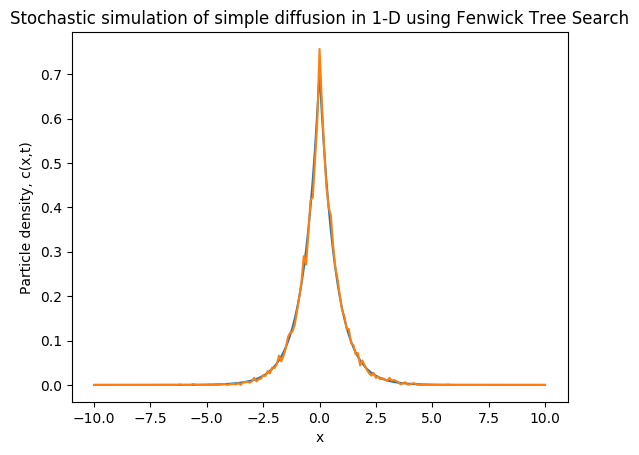

PyObject <matplotlib.text.Text object at 0x133aa48d0>

In [21]:
# Part 2
# Using Fenwick tree Search

L=10.0
N=10000
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1
Dexp = randexp(N)
Dexp = [Dexp; Dexp]
t=0.0


r = (Dexp./2.0)./(dx*dx)
totalRate = sum(r)
dt = 1.0/totalRate
T=1.0

#Creating Tree
values = Array{KVPair}(2*N)
for i=1:2*N
    values[i]=KVPair(i,r[i])
end
T3 = Nullable{FTree}(FTree(KVPair(0,0.0)))
T3 = buildFTree(T3, values);

# Thisvalues[i] is the main loop
while t < T
    # Pick an event
    ran = rand()*totalRate
    l = intervalmembership(T3, ran).key
    if l<=N
        hop = 1
        particleId = l
    else
        hop = -1
        particleId=l-N
    end
    Y[particleId]+=hop
    t+=dt

end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
function solution(x, D, t)
    return exp(-sqrt(2/(D*t))*abs(x))/(sqrt(2*D*t))
end
P1 = solution.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot(X, P, label="Numerical estimate of particle density")
xlabel("x")
ylabel("Particle density, c(x,t)")
title("Stochastic simulation of simple diffusion in 1-D using Fenwick Tree Search")
  